# Corona in Hamburg

In [1]:
import datetime
import re
import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [2]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
FETCH_HISTORIC_DATA = False

In [3]:
def parse_data(r):
    soup = bs4.BeautifulSoup(r.text)
    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Beträgt die Anzahl der Neuinfektionen"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            with open("corona-hamburg-daily.csv", "r") as f:
                lines = [line.strip() for line in f]

            with open("corona-hamburg-daily.csv", "a") as f:
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find("h3", text="Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken")
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp,"total"]
        active_cases = [timestamp,"active"]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip())
            cases = (
                row.find(attrs={"data-label": "Fälle vergangene 14 Tage"})
                or row.find(attrs={"data-label": "Fälle letzte 14 Tage"})
            )
            if cases:
                active_cases.append(cases.text.strip())

        with open("corona-hamburg.csv") as f:
            lines = [line.strip() for line in f]
        
        with open("corona-hamburg.csv", "a") as f:
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2:
                f.write(f"{total_cases_line}\n")

            active_cases_line = ",".join(active_cases)
            if active_cases_line not in lines and len(active_cases) > 2:
                f.write(f"{active_cases_line}\n")

In [4]:
if FETCH_HISTORIC_DATA:
    r = requests.get(f"http://web.archive.org/cdx/search/cdx?output=json&url={CORONA_DATA_URL}")
    data = r.json()
    header = data[0]
    historic_records = [dict(zip(header, row)) for row in data[1:]]

In [5]:
if FETCH_HISTORIC_DATA:
    for record in historic_records:
        r = requests.get(f"http://web.archive.org/web/{record['timestamp']}/{CORONA_DATA_URL}")
        if r.ok:
            parse_data(r)

In [6]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    parse_data(r)

In [7]:
with open("corona-hamburg-daily.csv") as f:
    daily_cases = pd.read_csv(f, index_col=0, squeeze=True, parse_dates=True).sort_index()
    daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()
    daily_cases_rolling14 = daily_cases.rolling(14).sum().dropna()

In [8]:
with open("corona-hamburg.csv") as f:
    df = pd.read_csv(f, index_col=0, parse_dates=True)

In [9]:
total_cases = df[df["type"] == "total"].drop(["type"], axis="columns").astype(int)
active_cases = df[df["type"] == "active"].drop(["type"], axis="columns").astype(int)
new_cases = total_cases.diff().dropna().astype(int)

In [10]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [11]:
def stackplot(df, title):
    plt.stackplot(df.index, *df.values.T, labels=df.columns)
    plt.legend(loc="upper left")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.xticks(rotation=60)
    plt.grid()

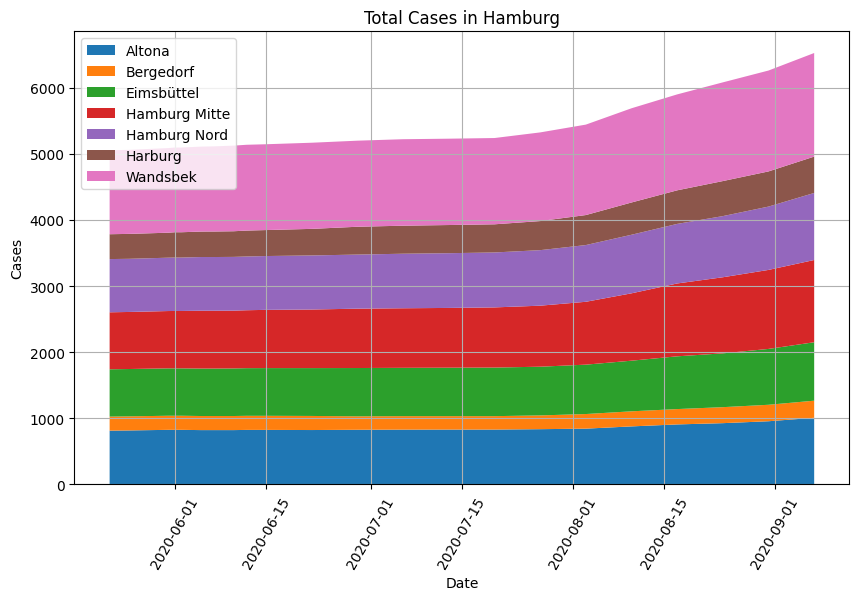

In [12]:
stackplot(total_cases, "Total Cases in Hamburg")
plt.show()

In [13]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-05-22,814,212,716,862,805,376,1270,5055
2020-05-25,817,213,716,863,804,377,1271,5061
2020-05-31,826,213,717,867,807,378,1280,5088
2020-06-01,826,213,717,868,808,383,1281,5096
2020-06-02,826,213,717,868,808,383,1281,5096
2020-06-05,822,213,718,875,812,385,1285,5110
2020-06-06,822,213,718,875,812,386,1286,5112
2020-06-07,822,213,718,875,812,386,1288,5114
2020-06-10,822,213,720,874,813,388,1295,5125


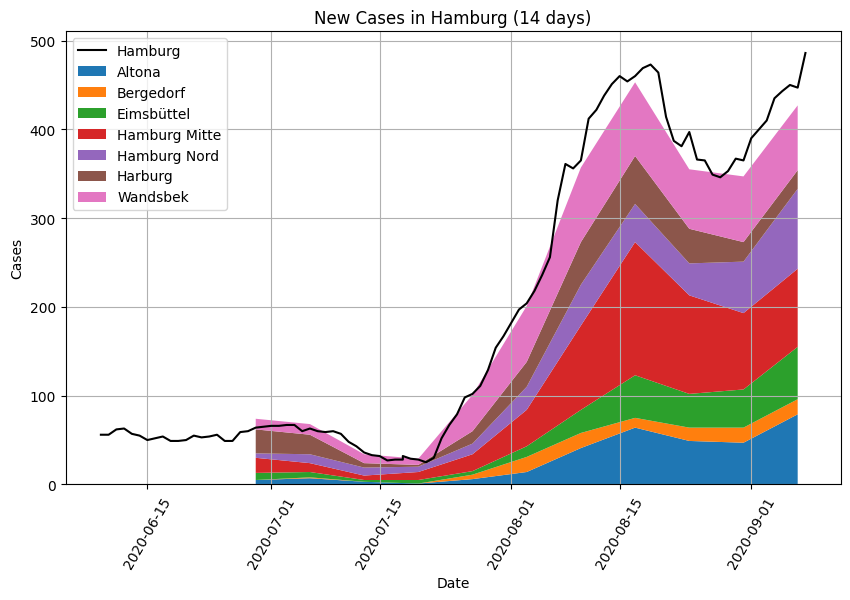

In [14]:
stackplot(active_cases, "New Cases in Hamburg (14 days)")
plt.plot(daily_cases_rolling14.index, daily_cases_rolling14.values, "black", label="Hamburg")
plt.legend(loc="upper left")
plt.show()

In [15]:
active_cases["Hamburg"] = active_cases.sum("columns")
active_cases

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-06-29,5,0,8,17,5,27,12,74
2020-07-06,7,1,6,10,10,22,12,68
2020-07-13,3,0,2,5,9,5,10,34
2020-07-20,1,0,4,9,6,2,7,29
2020-07-27,6,5,4,19,12,14,41,101
2020-08-03,14,17,12,41,26,28,63,201
2020-08-10,41,17,26,95,46,48,84,357
2020-08-17,64,11,48,150,43,54,83,453
2020-08-24,49,15,38,111,36,39,67,355


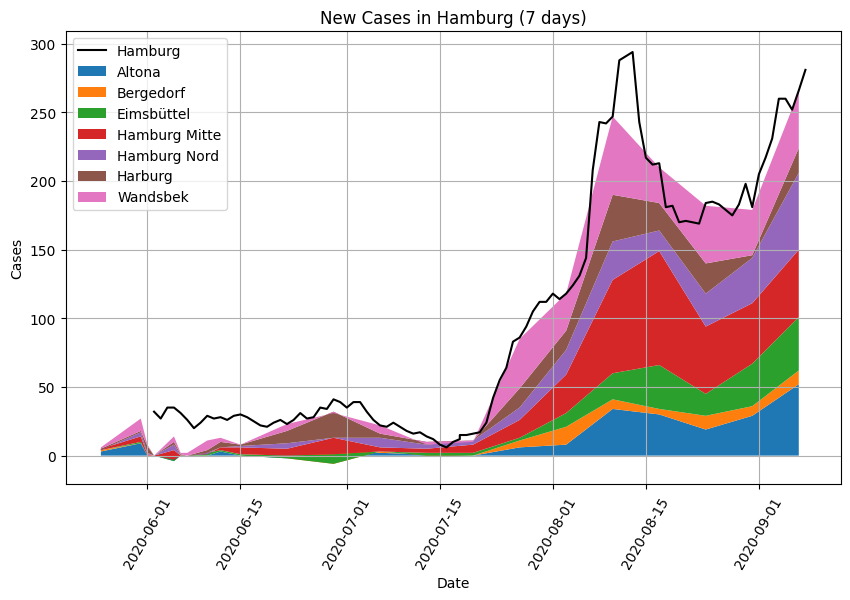

In [16]:
stackplot(new_cases, "New Cases in Hamburg (7 days)")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
plt.legend(loc="upper left")
plt.show()

In [17]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-05-25,3,1,0,1,-1,1,1,6
2020-05-31,9,0,1,4,3,1,9,27
2020-06-01,0,0,0,1,1,5,1,8
2020-06-02,0,0,0,0,0,0,0,0
2020-06-05,-4,0,1,7,4,2,4,14
2020-06-06,0,0,0,0,0,1,1,2
2020-06-07,0,0,0,0,0,0,2,2
2020-06-10,0,0,2,-1,1,2,7,11
2020-06-12,3,0,1,2,0,4,3,13
